In [29]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier

In [30]:
ignore = ['TroponinI', 'Fibrinogen', 'EtCO2', 'Bilirubin_direct']

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [31]:
def SIRS(row):
    sirs = ['HR', 'Temp', 'PaCO2', 'Resp', 'WBC']
    counter_sirs = 0
    if row['HR'] > 90:
        counter_sirs +=1
    if row['Temp'] < 36 or row['Temp'] > 38:
        counter_sirs += 1
    if row['PaCO2'] < 32 or row['Resp'] > 20:
        counter_sirs += 1
    if row['WBC'] > 12000 or row['WBC'] < 4000:
        counter_sirs += 1
    return counter_sirs


def transform_data_with_SIRS(df):
    """
    Returns the whole df if the patient didn't have sepsis (and label 0), or the truncated df if the patient had sepsis
    (up until the first row with SepsisLabel=1, and label 1). In addition create new SIRS column - count the creiteria number
    """
    
    df['SIRS'] = df.apply(SIRS, axis=1)
    
    if df['SepsisLabel'].sum() == 0:
        return df.drop(columns='SepsisLabel').drop(columns=ignore), 0
    ind = df.SepsisLabel.where(df.SepsisLabel == 1).first_valid_index()
    return df.drop(columns='SepsisLabel').drop(columns=ignore).loc[0:ind], 1

def transform_data_with_SIRS_mice(df):
    """
    Returns the whole df if the patient didn't have sepsis (and label 0), or the truncated df if the patient had sepsis
    (up until the first row with SepsisLabel=1, and label 1). In addition create new SIRS column - count the creiteria number
    """
    
    df['SIRS'] = df.apply(SIRS, axis=1)
    
    if df['SepsisLabel'].sum() == 0:
        return df.drop(columns='SepsisLabel').drop(columns=ignore_mice_A), 0
    ind = df.SepsisLabel.where(df.SepsisLabel == 1).first_valid_index()
    return df.drop(columns='SepsisLabel').drop(columns=ignore_mice_A).loc[0:ind], 1

# Mean imputation

In [32]:
X_train = []
Y_train = []
for file in os.listdir('../data/train/'):
    df = pd.read_csv(f"../data/train/{file}", sep='|')
    transformed_data, label = transform_data_with_SIRS(df)
    transformed_data['ICULOS'] = transformed_data['ICULOS'].max()
    mean_data = pd.DataFrame(transformed_data.mean()).T
    X_train.append(mean_data)
    Y_train.append(label)
all_data_means = pd.concat(X_train).reset_index(drop=True)

In [33]:
# leave one column of unit and impute by most frequent value
all_data_means = all_data_means.drop(columns='Unit2')
most_freq_unit = all_data_means['Unit1'].value_counts().index[0]
all_data_means['Unit1'] = all_data_means['Unit1'].fillna(most_freq_unit)
# mean imputation to all other columns
mean_imp = all_data_means.mean()
all_data_means = all_data_means.fillna(all_data_means.mean())
all_data_means

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,Hgb,PTT,WBC,Platelets,Age,Gender,Unit1,HospAdmTime,ICULOS,SIRS
0,61.215909,97.269231,36.857143,124.163265,58.135417,37.214286,22.771739,-0.483634,24.386175,0.375000,...,9.85000,36.950855,10.000000,78.000000,77.00,0.0,0.0,-679.93,52.0,0.576923
1,102.000000,98.000000,36.838671,113.500000,68.165000,64.096169,19.500000,-0.483634,24.386175,1.000000,...,10.71697,36.950855,11.013111,207.232551,80.47,0.0,0.0,-252.79,3.0,0.666667
2,90.023256,98.921053,37.028333,112.135135,83.630541,64.096169,14.918605,-0.483634,24.000000,0.637069,...,10.30000,36.950855,5.000000,266.500000,59.47,1.0,0.0,-0.03,51.0,0.437500
3,102.203704,97.285714,36.561765,123.634615,78.870370,66.538462,17.629630,-3.642857,22.000000,0.555556,...,10.87500,39.900000,16.050000,185.500000,79.16,0.0,0.0,0.80,28.0,1.259259
4,79.851852,96.296296,36.890909,105.814815,77.423077,60.888889,16.037037,-0.483634,24.386175,0.637069,...,12.15000,36.950855,13.350000,141.000000,59.00,1.0,0.0,-14.04,45.0,0.177778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,64.765625,99.016129,36.461429,102.075000,69.483871,50.325000,16.609375,-5.000000,18.500000,0.637069,...,11.75000,85.166667,9.350000,279.000000,71.89,1.0,0.0,-62.71,35.0,0.400000
19996,72.322581,96.725806,36.400000,115.600000,82.400000,62.933333,20.574074,-0.483634,24.386175,0.637069,...,10.00000,36.950855,8.300000,454.000000,73.00,0.0,0.0,-3.77,33.0,0.484848
19997,81.675676,97.869565,36.992857,112.162162,83.441351,64.096169,18.441176,-0.483634,24.000000,0.637069,...,11.70000,34.200000,10.900000,255.500000,42.34,1.0,0.0,-0.02,41.0,0.390244
19998,66.015152,97.000000,36.957727,136.257576,65.136667,44.532258,14.303030,-0.285714,24.000000,0.637069,...,8.85000,26.500000,13.700000,209.500000,69.78,1.0,0.0,3.81,36.0,0.151515


In [34]:
X_test = []
Y_test = []
for file in os.listdir('../data/test/'):
    df = pd.read_csv(f"../data/test/{file}", sep='|')
    transformed_data, label = transform_data_with_SIRS(df)
    transformed_data['ICULOS'] = transformed_data['ICULOS'].max()
    mean_data = pd.DataFrame(transformed_data.mean()).T
    X_test.append(mean_data)
    Y_test.append(label)
all_data_means_test = pd.concat(X_test).reset_index(drop=True)

In [35]:
all_data_means_test = pd.concat(X_test).reset_index(drop=True)
all_data_means_test=all_data_means_test.drop(columns='Unit2')
all_data_means_test['Unit1'] = all_data_means_test['Unit1'].fillna(most_freq_unit)
all_data_means_test = all_data_means_test.fillna(mean_imp)
all_data_means_test

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,Hgb,PTT,WBC,Platelets,Age,Gender,Unit1,HospAdmTime,ICULOS,SIRS
0,62.464286,98.428571,36.600000,151.142857,107.250000,79.571429,18.583333,-0.483634,24.386175,0.637069,...,12.300000,36.950855,4.500000,238.000000,58.00,0.0,0.0,-0.03,15.0,0.133333
1,70.400000,94.200000,36.600000,139.400000,82.333333,63.466667,19.933333,-0.483634,24.386175,0.637069,...,10.716970,36.950855,11.013111,207.232551,82.00,0.0,1.0,-6.64,16.0,0.312500
2,60.150000,95.825000,36.232500,122.575000,74.400000,50.425000,19.825000,-0.483634,25.000000,0.637069,...,11.200000,38.800000,12.700000,106.000000,83.39,1.0,0.0,-287.87,21.0,0.428571
3,85.769231,99.961538,36.843333,114.269231,83.653846,64.423077,20.115385,-0.483634,22.666667,0.400000,...,11.266667,26.100000,11.533333,319.666667,39.17,0.0,0.0,-5.21,28.0,0.714286
4,86.658537,99.512500,36.705000,113.666667,79.800000,64.096169,15.487805,-0.483634,24.000000,0.400000,...,10.750000,32.000000,8.250000,359.000000,23.73,1.0,0.0,-0.02,42.0,0.609756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,78.968750,95.406250,36.657500,127.041562,82.531250,59.718750,16.531250,-0.483634,23.666667,0.637069,...,12.950000,26.133333,12.550000,186.000000,64.24,1.0,0.0,-0.02,44.0,0.170732
9996,75.550000,97.769231,37.150000,115.200000,77.477667,64.096169,23.775862,-7.000000,18.500000,0.637069,...,10.433333,29.550000,10.940000,171.500000,76.46,0.0,0.0,-0.02,39.0,0.641026
9997,90.750000,95.750000,37.350000,138.250000,100.000000,72.750000,17.000000,-0.483634,24.386175,0.637069,...,10.716970,36.950855,11.013111,207.232551,37.00,1.0,0.0,-5.29,15.0,0.363636
9998,95.576923,97.653846,36.450000,130.500000,95.461538,72.538462,20.461538,-0.483634,24.386175,0.637069,...,11.900000,26.200000,5.200000,225.000000,62.00,1.0,0.0,-5.10,14.0,1.500000


## Random Forest - Mean Imputation

### Training - Grid Search

In [39]:
f1_scores = {'A':[], 'B':[], 'C':[]}

ignore_B = ['Lactate', 'SaO2', 'BaseExcess', 'Alkalinephos', 'Bilirubin_total', 'AST']
ignore_C = ['FiO2', 'PaCO2', 'pH', 'HCO3', 'PTT']
ignores = {'A': None, 'B':ignore_B, 'C':[*ignore_B, *ignore_C]}

n_estimators = None
ignore_type=None

score = 0

for ig_key in ['A', 'B', 'C']:
    for n in range(50,200,10):
        rf = RandomForestClassifier(n_estimators=n, verbose=1, random_state=6)
        if ig_key == 'A':
            rf.fit(all_data_means, Y_train)
            y_pred = rf.predict(all_data_means_test)
        else:
            rf.fit(all_data_means.drop(columns=ignores[ig_key]), Y_train)
            y_pred = rf.predict(all_data_means_test.drop(columns=ignores[ig_key]))
        new_score = f1_score(Y_test, y_pred)
        f1_scores[ig_key].append(new_score)
        if new_score > score:
            score = new_score
            n_estimators = n
            ignore_type = ig_key
        
print('f1 test score:', score)
print(f"n_estimators={n_estimators}, ignore_type={ignore_type}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    8.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    8.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    9.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:   25.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:   24.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:   22.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Us

f1 test score: 0.6710526315789473
n_estimators=130, ignore_type=C


[Parallel(n_jobs=1)]: Done 190 out of 190 | elapsed:    0.5s finished


### Final Model

In [40]:
rf = RandomForestClassifier(n_estimators=n_estimators, random_state=6, verbose=1)
if ignore_type == 'A':
    rf.fit(all_data_means, Y_train)
    y_pred = rf.predict(all_data_means_test)
else:
    rf.fit(all_data_means.drop(columns=ignores[ignore_type]), Y_train)
    y_pred = rf.predict(all_data_means_test.drop(columns=ignores[ignore_type]))
test_f1_score = f1_score(Y_test, y_pred)
test_acuuracy = accuracy_score(Y_test, y_pred)
test_recall = recall_score(Y_test, y_pred)

print(f"Random forest with mean imputation and SIRS (n_estimators = {n_estimators}), ignore_type={ignore_type}")
print(f"F1 score: {test_f1_score}, test acuracy: {test_acuuracy}, recall: {test_recall}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:   16.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Random forest with mean imputation and SIRS (n_estimators = 130), ignore_type=C
F1 score: 0.6710526315789473, test acuracy: 0.96, recall: 0.5506072874493927


[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:    0.3s finished


### Analysis

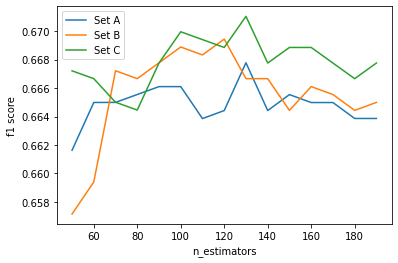

In [41]:
x = range(50,200,10)
plt.plot(x, f1_scores['A'], label = "Set A")
plt.plot(x, f1_scores['B'], label = "Set B")
plt.plot(x, f1_scores['C'], label = "Set C")
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('f1 score')
plt.show()